Example text

In [1]:
data = "example python code"
data

'example python code'

In [2]:
print(data)

example python code


Read data from csv

In [3]:
from pandas import read_csv
filename = 'dataset\\consumption_split\\CPI_ACPI_COI_RT_A-filtered-2021-03-21.csv'
dataset = read_csv(filename)

In [4]:
dataset.head()

,ref_area.label,indicator.label,source.label,classif1.label,time,obs_value,note_classif.label,note_indicator.label,note_source.label
0,Aruba,"National consumer price index (CPI), annual ra...",ABW - CPS - Consumer Price Survey,COICOP (Selected categories): General,1985,3.72,NaN,NaN,NaN
1,Aruba,"National consumer price index (CPI), annual ra...",ABW - CPS - Consumer Price Survey,COICOP (Selected categories): Food and non-alc...,1985,-0.20,NaN,NaN,NaN
2,Aruba,"National consumer price index (CPI), annual ra...",ABW - CPS - Consumer Price Survey,COICOP (Selected categories): Clothing and foo...,1985,0.79,NaN,NaN,NaN
3,Aruba,"National consumer price index (CPI), annual ra...",ABW - CPS - Consumer Price Survey,"COICOP (Selected categories): Electricity, gas...",1985,6.86,NaN,NaN,NaN
4,Aruba,"National consumer price index (CPI), annual ra...",ABW - CPS - Consumer Price Survey,COICOP (Selected categories): Actual and imput...,1985,2.84,NaN,NaN,NaN


In [5]:
filename = 'dataset\\living_index\\living_index.csv'
df = read_csv(filename)

In [6]:
byCountry = [dfCountry  for country,dfCountry in df.groupby('Country')]

C:\Users\Vergenter\miniconda3\envs\workenv\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


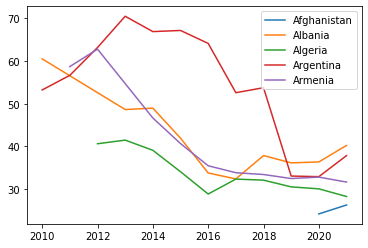

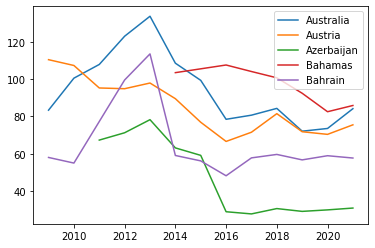

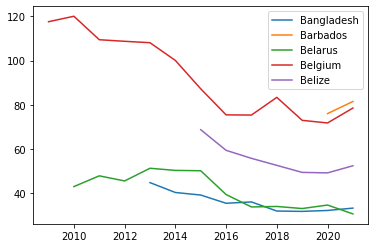

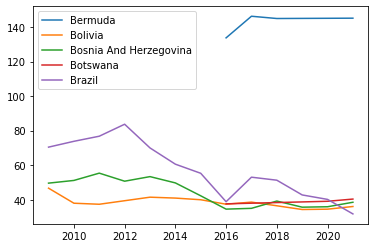

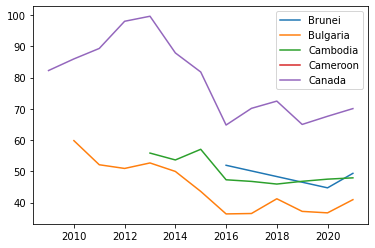

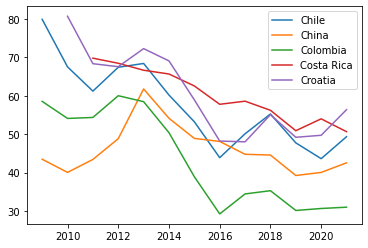

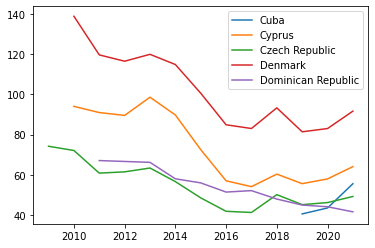

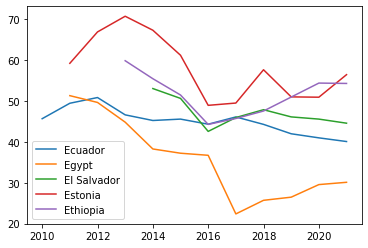

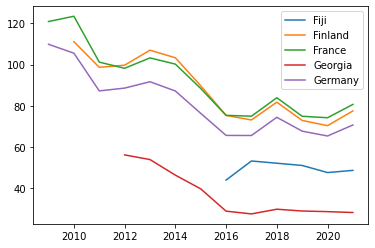

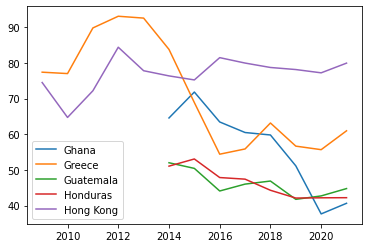

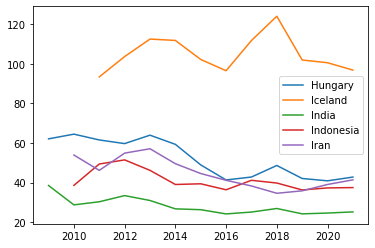

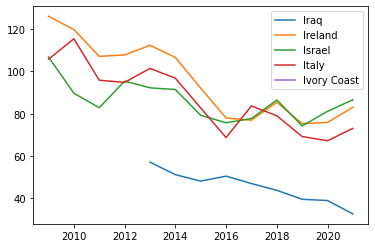

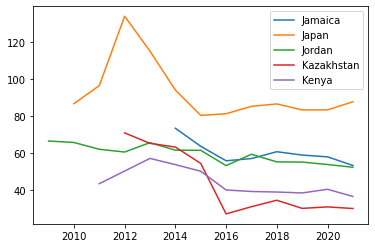

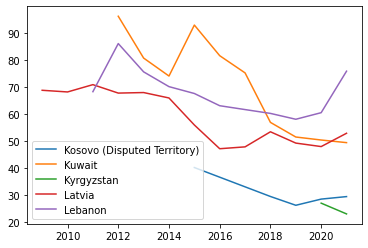

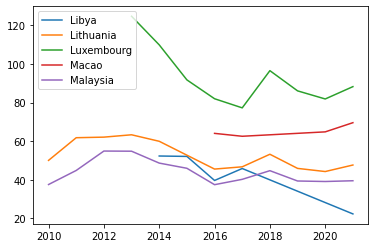

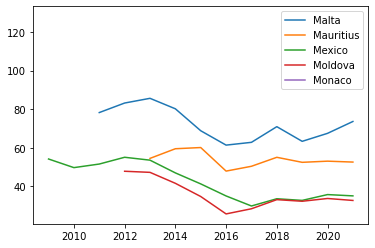

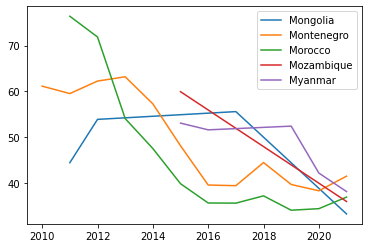

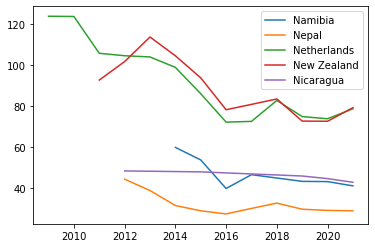

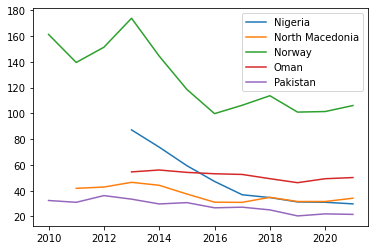

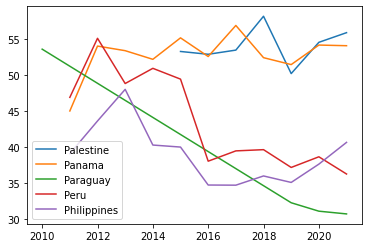

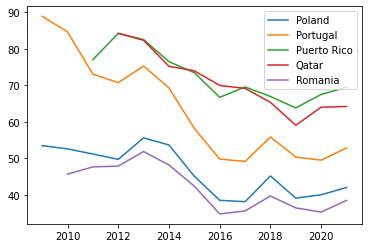

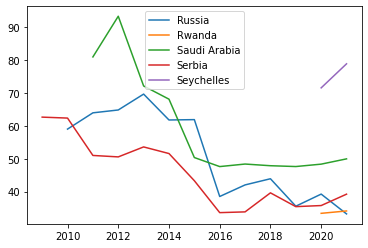

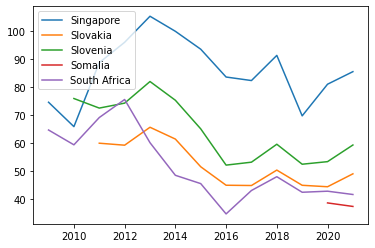

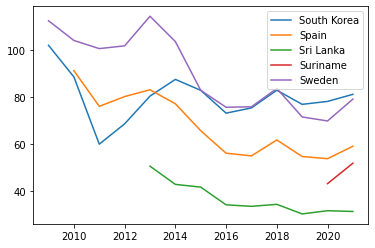

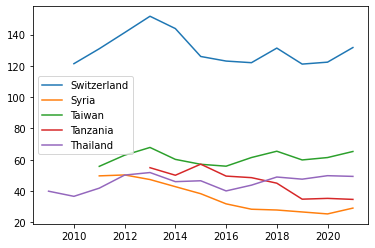

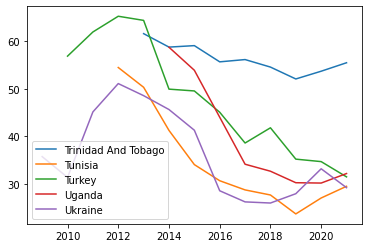

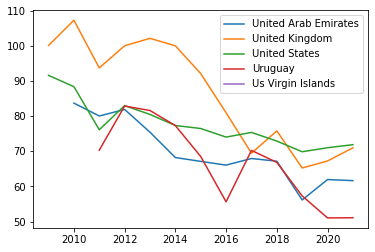

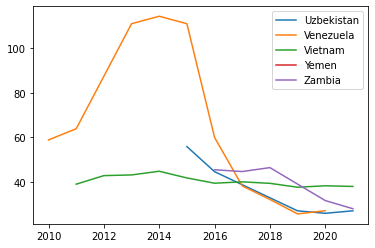

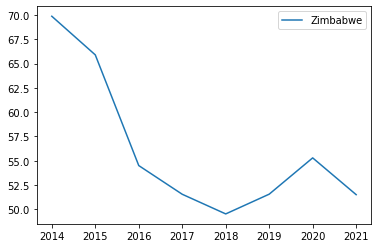

In [7]:
import numpy as np
import matplotlib.pyplot as plt

countries = [country["Country"].values[0] for country in byCountry]
# print(countries)
for i in range(0,len(byCountry),5):
    plt.figure();
    end = min(len(byCountry),i+5)
    for x in range(i,end):
        plt.plot(byCountry[x]["Year"],byCountry[x]["Cost of Living Index"])
    plt.legend(countries[i:end])

plt.show()

#     x, y = lists # unpack a list of pairs into two tuples
#     print(y)

## Fourier tranform

In [13]:
poland_Cost_of_living = df.loc[df['Country'] == "Poland"][["Cost of Living Index","Year"]]

In [38]:
years=poland_Cost_of_living.values[:,1]
cost_of_living_index=poland_Cost_of_living.values[:,0]

In [20]:
from scipy.fft import fft
result = fft(poland_Cost_of_living.values)

In [ ]:
import numpy as np
from scipy.fftpack import fft

# Number of sample points
N = 12
T = 1
x = T*np.arange(N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = 1/(N*T)*np.arange(N//2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

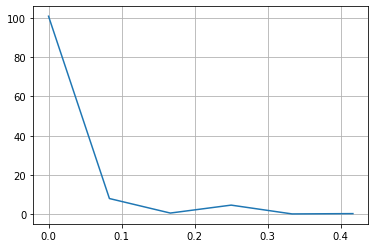

In [39]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = 12
# sample spacing
T = 1
yf = fft(cost_of_living_index)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

## Linear regression

In [32]:
x=poland_Cost_of_living.values[:,1]
y=poland_Cost_of_living.values[:,0]
predict_x = [x for x in range(2009,2026)]

In [33]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [34]:
model = LinearRegression(n_jobs = -1)
model.fit(np.reshape(x,(-1,1)), y)
predicted_y = model.predict(np.reshape(predict_x,(-1,1)))

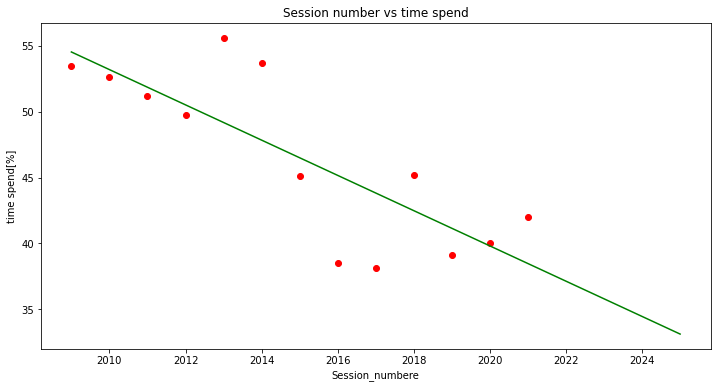

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(x, y, color = "red")
plt.plot(predict_x, predicted_y, color = "green")
plt.title("Session number vs time spend")
plt.xlabel("Session_numbere")
plt.ylabel("time spend[%]")
plt.show()

In [ ]:
#ToDo regresja wielomianowa